# Data Science with Python final project

### Question: How popular will a new track probably be given a selected amount of attributes

Why is this interesting?

When you know how popular a new track will be, you can make better decisions regarding advertisment budgets, cost for the music rights etc.

## Imports

In [114]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, glob
import json
import sqlite3 as sl
from sqlalchemy import create_engine
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import text
from collections import defaultdict

# Loading Data from DB to DataFrames

#### Tables tracks, lyrics and features provide information about the tracks which could be useful to predict the popularity

In [42]:
engine = create_engine("sqlite:///spotify.db")
tracks_df = pd.read_sql_table("tracks", engine)
lyrics_df = pd.read_sql_table("lyrics", engine)
features_df = pd.read_sql_table("features", engine)

### Check how to do the JOIN

In [43]:
print(f"DataFrame tracks_df has {tracks_df.shape[0]} rows.")
print(f"DataFrame lyrics_df has {lyrics_df.shape[0]} rows.")
print(f"DataFrame features_df has {features_df.shape[0]} rows.")

DataFrame tracks_df has 301508 rows.
DataFrame lyrics_df has 183320 rows.
DataFrame features_df has 301545 rows.


tracks_df and features_df have almost the same amount of rows, but lyrics_df way less
-> check what extra information lyrics_df provides and if we could fill the missing data for the relevant columns

In [44]:
lyrics_df.head()

,uri,title,artist,language,lyrics
0,spotify:track:6Nr3QjImPUhCpUgnykO7hm,Fly In,Lil Wayne,en,"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."
1,spotify:track:4P7VFiaZb3xrXoqGwZXC3J,Lollipop Remix,Lil Wayne,en,[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...
2,spotify:track:4T90fwS4tw1Qlxige4a9mK,Lollipop Remix,Lil Wayne,en,[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...
3,spotify:track:0s5bCEmMYwttQIZLHLwOF3,Lollipop Remix,Lil Wayne,en,[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...
4,spotify:track:6Y6f7LSvHxUA61ItYiSMKE,Money On My Mind,Lil Wayne,en,"[Intro]\nYeah\nMoney on my mind, money on my m..."


Only relevant column is the language column, which we could fill up by what other languages the Artist has used

### -> Using OUTERJOIN

In [57]:
df = tracks_df.merge(lyrics_df, how="outer", on="uri")
df = df.merge(features_df, how="outer", on="uri")
df.set_index("uri", inplace=True)

In [58]:
df.head(10)

,type_x,name,duration_ms_x,popularity,explicit,is_local,available_markets,preview_url,disc_number,track_number,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:0ltRc18CGfqQXVoh9HmJEU,track,There'll Come A Day,203213.0,33.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",None,1.0,5.0,...,0.802,0.000000,4.0,0.1930,-4.046,1.0,0.0411,159.017,4.0,0.353
spotify:track:6ZOPMDgEU9gPg0gtlgTc3E,track,Alive,193125.0,17.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",https://p.scdn.co/mp3-preview/ced485344d371879...,1.0,1.0,...,0.830,0.000000,8.0,0.1680,-4.448,0.0,0.0837,127.901,4.0,0.221
spotify:track:28Wu2b54s7TPn0o8xSteeQ,track,Kill Em With Kindness - Felix Cartal Remix,196293.0,0.0,0.0,0.0,,None,1.0,1.0,...,0.774,0.000005,10.0,0.2530,-2.886,0.0,0.0365,121.970,4.0,0.503
spotify:track:20wgVaEsW9ElKWEZkZYOrm,track,Te Vas,169346.0,0.0,0.0,0.0,,None,1.0,10.0,...,0.527,0.000000,5.0,0.1750,-7.995,0.0,0.1090,90.043,4.0,0.492
spotify:track:4AZlgqkThHYfPSstdVuy2f,track,Goin' Back Down,225740.0,0.0,0.0,0.0,,None,1.0,3.0,...,0.877,0.000013,10.0,0.3070,-4.924,0.0,0.1060,170.211,4.0,0.632
spotify:track:16cCeDTKDk4MAMIjhJJMoq,track,Waiting For Your Love,248255.0,12.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",https://p.scdn.co/mp3-preview/e0d2b706435ec324...,1.0,1.0,...,0.766,0.012700,0.0,0.1080,-5.717,1.0,0.0341,121.061,4.0,0.457
spotify:track:23NWg3ow2UrMun7zRXHfce,track,Good Together,195486.0,0.0,0.0,0.0,,None,1.0,1.0,...,0.623,0.000000,1.0,0.4920,-7.006,1.0,0.1050,104.035,4.0,0.495
spotify:track:0Rg6WHOKKrcpVsJeWKmbmZ,track,悪いことばかり学んで,222533.0,5.0,0.0,0.0,JP,https://p.scdn.co/mp3-preview/12c525da8d91f462...,1.0,3.0,...,0.879,0.000000,9.0,0.2720,-2.850,0.0,0.0590,79.997,4.0,0.708
spotify:track:309TfpIu0xvJVFQuYjThq8,track,Drunk,176243.0,0.0,0.0,0.0,,None,1.0,6.0,...,0.302,0.000034,3.0,0.0989,-6.020,1.0,0.0304,87.827,4.0,0.238


# Data Exploration

In [59]:
df.describe()

,duration_ms_x,popularity,explicit,is_local,disc_number,track_number,acousticness,danceability,duration_ms_y,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,3.015080e+05,301508.000000,301508.000000,301508.0,301508.000000,301508.000000,301545.000000,301545.000000,3.015450e+05,301545.000000,301545.000000,301545.000000,301545.000000,301545.000000,301545.000000,301545.000000,301545.000000,301545.000000,301545.000000
mean,2.406148e+05,16.801889,0.122222,0.0,1.033714,6.073889,0.300412,0.564159,2.407267e+05,0.615033,0.146077,5.253063,0.203609,-8.495913,0.659271,0.087874,120.826521,3.905112,0.470279
std,1.110043e+05,18.569157,0.327543,0.0,0.327904,6.150757,0.326362,0.175332,1.102750e+05,0.247393,0.295944,3.571795,0.180150,4.822996,0.473955,0.102617,29.510038,0.416629,0.256793
min,0.000000e+00,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,2.000000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.914660e+05,0.000000,0.000000,0.0,1.000000,2.000000,0.019200,0.450000,1.915300e+05,0.447000,0.000000,2.000000,0.096200,-10.320000,0.000000,0.034800,97.917000,4.000000,0.259000
50%,2.256335e+05,11.000000,0.000000,0.0,1.000000,5.000000,0.152000,0.576000,2.256670e+05,0.653000,0.000069,5.000000,0.127000,-7.272000,1.000000,0.047100,120.050000,4.000000,0.457000
75%,2.694268e+05,31.000000,0.000000,0.0,1.000000,9.000000,0.550000,0.693000,2.694590e+05,0.819000,0.047100,8.000000,0.257000,-5.306000,1.000000,0.088100,139.853000,4.000000,0.674000
max,6.348017e+06,91.000000,1.000000,0.0,43.000000,167.000000,0.996000,0.991000,5.279768e+06,1.000000,1.000000,11.000000,1.000000,3.744000,1.000000,0.965000,247.938000,5.000000,1.000000


In [60]:
#sns.pairplot(df)
#plt.show()

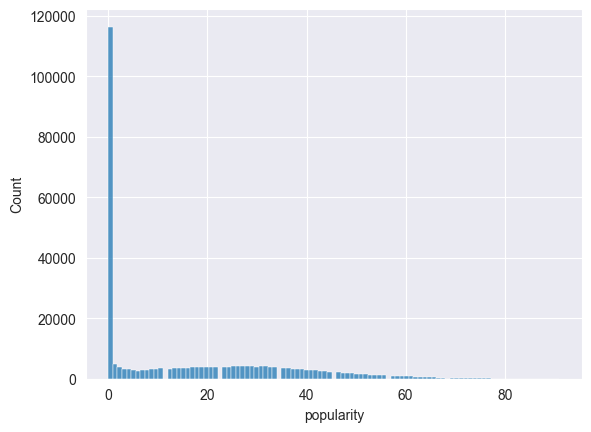

In [61]:
sns.histplot(df["popularity"])
plt.show()

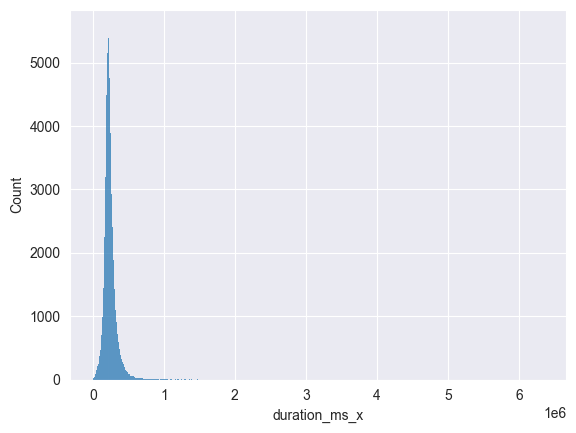

In [62]:
sns.histplot(df["duration_ms_x"])
plt.show()

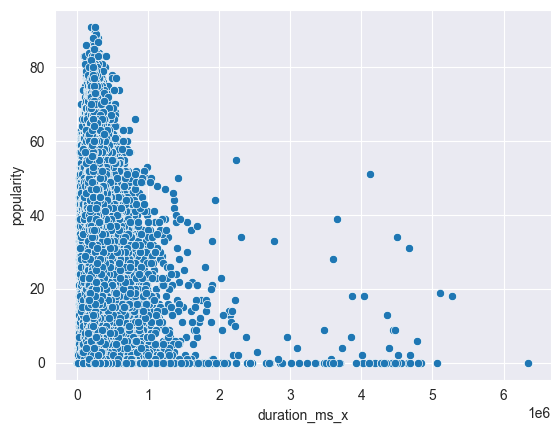

In [63]:
sns.scatterplot(x=df["duration_ms_x"], y=df["popularity"])
plt.show()

# Data transformation

#### Check if we can delete type_x and type_y

In [64]:
df["type_x"].unique()
# the documentation also says it just says the type (track)

array(['track', nan], dtype=object)

In [65]:
df["type_y"].unique()
# the documentation also says it just says the type (track)

array(['audio_features', nan], dtype=object)

-> Only 1 value so no information

In [66]:
del df["type_x"]
del df["type_y"]

### Deleting duplicated columns

##### title and name have the same meaning
-> check which one has more NaN values and delete it

In [67]:
print(f"title has {df['title'].isnull().sum()} NaN values.")
print(f"name has {df['name'].isnull().sum()} NaN values.")

title has 118226 NaN values.
name has 38 NaN values.


In [68]:
del df["title"]

##### Is there a difference between duration_ms_x and duration_ms_y?

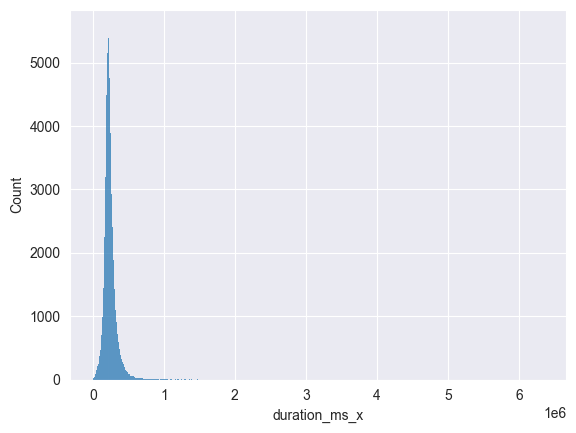

In [69]:
sns.histplot(df["duration_ms_x"])
plt.show()

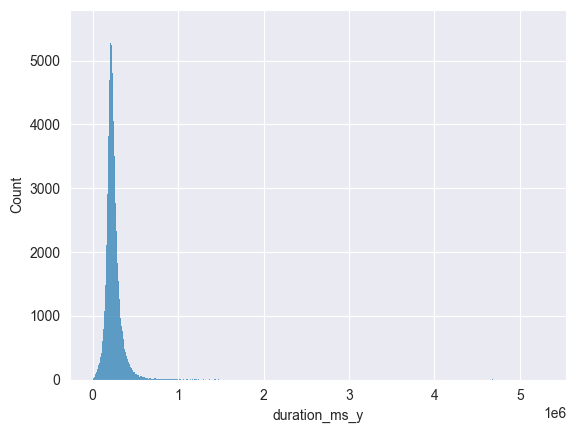

In [70]:
sns.histplot(df["duration_ms_y"])
plt.show()

In [71]:
print(f'{df[df["duration_ms_x"] != df["duration_ms_y"]].shape[0]/df.shape[0]*100//1}% of the tracks have different duration_ms_x than duration_ms_y')

37.0% of the tracks have different duration_ms_x than duration_ms_y


-> From looking at the documentation they are probably the duration from the track and the feature table, so none of them is more credible than the other, so we take the mean

In [72]:
df["duration"] = (df["duration_ms_y"] + df["duration_ms_x"]) / 2

Test if it is the mean

In [73]:
df[["duration_ms_x", "duration_ms_y", "duration"]].sample(10)

,duration_ms_x,duration_ms_y,duration
uri,,,
spotify:track:7xbgcwhFLETsHgEHChBN8X,184933.0,184933.0,184933.0
spotify:track:3gZUflBBfgS3QiTSTg0hk0,208671.0,208671.0,208671.0
spotify:track:5Q1sfEJnyGQbc8XmwQzmEh,179813.0,179813.0,179813.0
spotify:track:7eg2ybD6Qo6eLXg3UdSB9q,362853.0,362853.0,362853.0
spotify:track:3PerbGU5AAxDDSKMDGryaa,240960.0,240960.0,240960.0
spotify:track:0UFRX4yCQN0PgXaRhNd63N,541000.0,541000.0,541000.0
spotify:track:22SbLS4Atq2XG1267n3W7d,297773.0,297773.0,297773.0
spotify:track:5ligikF0zByEacrccEawGo,127933.0,127933.0,127933.0
spotify:track:18bjraoIs57fzdy29tl3bG,225506.0,225507.0,225506.5


In [74]:
del df["duration_ms_y"]
del df["duration_ms_x"]

#### See how many NaNs values each column has

In [75]:
for column in df:
    print(f"{column} has {df[column].isnull().sum()/df.shape[0]*100//1}% NaN values")

name has 0.0% NaN values
popularity has 0.0% NaN values
explicit has 0.0% NaN values
is_local has 0.0% NaN values
available_markets has 0.0% NaN values
preview_url has 50.0% NaN values
disc_number has 0.0% NaN values
track_number has 0.0% NaN values
artist has 39.0% NaN values
language has 40.0% NaN values
lyrics has 39.0% NaN values
acousticness has 0.0% NaN values
danceability has 0.0% NaN values
energy has 0.0% NaN values
instrumentalness has 0.0% NaN values
key has 0.0% NaN values
liveness has 0.0% NaN values
loudness has 0.0% NaN values
mode has 0.0% NaN values
speechiness has 0.0% NaN values
tempo has 0.0% NaN values
time_signature has 0.0% NaN values
valence has 0.0% NaN values
duration has 0.0% NaN values


-> Columns with high number of NaNs: preview_url, artist, language and lyrics

#### Fixing preview_url

There is no relevant information in the preview_url because the only information that could be useful is the ending (.de, .com,...) to see from which country the song is,
but this is already covered by available markets

In [76]:
del df["preview_url"]

#### Fixing language

In [77]:
print(f"{df['language'].isnull().sum()/df.shape[0]*100//1}% of the language entries are NaN.")

40.0% of the language entries are NaN.


##### Can we fill it up over the artist?

In [78]:
print(f'{df[df["language"].isna()]["artist"].isnull().sum()/df["language"].isnull().sum()*100//1}% of the rows with missing language have a missing artist value.')

96.0% of the rows with missing language have a missing artist value.


-> No, that won't be a solution

##### Can we fill it up over the language of the language of the name?

How many and what languages do we have?

In [79]:
languages = df["language"].unique()
print(f"There are {languages.shape[0]} unique languages in the language column.")
print("The Languages are: (language/number of tracks in this language)")
for language in languages:
    print(str(language) + ": " + str(df[df["language"] == language].shape[0]), end=" ")

There are 50 unique languages in the language column.
The Languages are: (language/number of tracks in this language)
nan: 0 en: 163995 ja: 74 pt: 909 None: 0 es: 11155 fil: 379 fr: 836 it: 338 fi: 36 de: 376 ko: 417 is: 39 tr: 123 da: 28 sv: 148 no: 19 uk: 1 hi: 56 ar: 40 ru: 32 ta: 15 he: 41 pl: 18 gl: 1 id: 15 zh: 13 nl: 22 vi: 1 el: 24 fa: 13 la: 6 ro: 6 cy: 2 af: 7 ca: 7 ur: 1 sq: 3 pa: 3 te: 2 ceb: 1 bg: 2 eo: 1 ga: 6 hr: 1 eu: 1 lt: 1 hu: 2 gd: 1 sk: 1 

##### Building classification model to fill up the nan values in the language column

In [80]:
### TODO

##### Check if we can use a language classification model to detect the language from the name

In [81]:
base_options = python.BaseOptions(model_asset_path="language_detector.tflite")
options = text.LanguageDetectorOptions(base_options=base_options)

In [82]:
with python.text.LanguageDetector.create_from_options(options) as detector:
    number_all = df[~df["language"].isnull()].shape[0]
    number_right_detected = 0
    number_not_detected = 0
    for index, row in df[~df["language"].isnull()].iterrows():
        detection_result = detector.detect(str(row["name"]))
        if len(detection_result.detections) > 0 and str(row["language"]) == str(detection_result.detections[0].language_code):
            number_right_detected += 1
        else:
            number_not_detected += 1
    print(f"Number of correct detected languages: {number_right_detected/number_all*100//1} (Precision)")
    print(f"Number of not detected languages: {number_not_detected/number_all*100//1}")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Number of correct detected languages: 85.0
Number of not detected languages: 14.0


In [83]:
with python.text.LanguageDetector.create_from_options(options) as detector:
    i = 0
    for index, row in df[df["language"].isnull()].iterrows():
        detection_result = detector.detect(str(row["name"]))
        if len(detection_result.detections) > 0:
            i += 1
            df.loc[index, "language"] = detection_result.detections[0].language_code
print(f"{df[df['language'].isnull()].shape[0]/ df.shape[0] * 100 // 1}% of the language values are still NaN.")

6595


-> There are no more ways to fill these missing values so we will drop the rows with missing language values

In [86]:
df.dropna(axis=0, subset=["language"], inplace=True)
print(f"{df[df['language'].isnull()].shape[0]} of the language values are still NaN.")

0 of the language values are still NaN.


#### Fixing artist

There is no way to fill the missing values, so we need to delete the entire column because 39% NaNs is very high

In [87]:
del df["artist"]

#### Fixing lyrics

There is no way to fill the missing values, so we need to delete the entire column because 39% NaNs is very high

In [88]:
del df["lyrics"]

#### Control if we handled all NaNs values

In [89]:
for column in df:
    print(f"{column} has {df[column].isnull().sum()} NaN values")

name has 18 NaN values
popularity has 18 NaN values
explicit has 18 NaN values
is_local has 18 NaN values
available_markets has 18 NaN values
disc_number has 18 NaN values
track_number has 18 NaN values
language has 0 NaN values
acousticness has 1 NaN values
danceability has 1 NaN values
energy has 1 NaN values
instrumentalness has 1 NaN values
key has 1 NaN values
liveness has 1 NaN values
loudness has 1 NaN values
mode has 1 NaN values
speechiness has 1 NaN values
tempo has 1 NaN values
time_signature has 1 NaN values
valence has 1 NaN values
duration has 19 NaN values


-> There are still a few NaN values but so few that we can just delete the regarding rows

In [90]:
df.dropna(inplace=True)

In [91]:
for column in df:
    print(f"{column} has {df[column].isnull().sum()} NaN values")

name has 0 NaN values
popularity has 0 NaN values
explicit has 0 NaN values
is_local has 0 NaN values
available_markets has 0 NaN values
disc_number has 0 NaN values
track_number has 0 NaN values
language has 0 NaN values
acousticness has 0 NaN values
danceability has 0 NaN values
energy has 0 NaN values
instrumentalness has 0 NaN values
key has 0 NaN values
liveness has 0 NaN values
loudness has 0 NaN values
mode has 0 NaN values
speechiness has 0 NaN values
tempo has 0 NaN values
time_signature has 0 NaN values
valence has 0 NaN values
duration has 0 NaN values


-> We handled all missing values

### Transform available_markets and language to numerical values

Check how many unique values there are to decide if we use one-hot-encoding or integer coding

In [92]:
print(f"There are {df['language'].unique().shape[0]} unique languages.")

There are 100 unique languages.


-> We would about 6x the amount of features with one-hot-encoding => Integer Coding

In [93]:
df.language = df.language.astype("category").cat.codes

Test if integer coding was successful

In [97]:
print(f"There are {df['language'].unique().shape[0]} different codes")
df["language"].sample(10)

There are 100 different codes


uri
spotify:track:42EfeKhnVCyCjiNKxC3nDT    17
spotify:track:5i0mySNOf08Q0HeIwuMmfl    17
spotify:track:1wBkInwdcTLnIUDvlzzr2G    17
spotify:track:1n8k5b8kbFWGyTyXEWN92f    70
spotify:track:5ug5eNxUoyrBi0tWQ0j0WN    17
spotify:track:4bfZ1tgMLB5MIzSOW1Anm7    19
spotify:track:0JwO5dONotY5mlVQDNaPKp    17
spotify:track:6rMep7y542tAjU1nOshYfy    17
spotify:track:2PEoQw82eyRqShG2u7nT1B    17
spotify:track:2okg3JvGjJZaUu1HnDdYPQ    25
Name: language, dtype: int8

-> 100 codes for 100 different languages

In [98]:
countries = set()
for index, row in df.iterrows():
    countries.update(set(str(row["available_markets"]).replace(" ", "").split(",")))
print(countries)
print(len(countries))

{'', 'GY', 'DE', 'JP', 'PT', 'CY', 'NP', 'IL', 'MZ', 'GQ', 'KE', 'MC', 'AM', 'PK', 'KR', 'HN', 'FJ', 'AG', 'ML', 'KN', 'BB', 'ZW', 'RW', 'IS', 'MG', 'TJ', 'VC', 'BT', 'JM', 'ID', 'FM', 'LY', 'UG', 'SN', 'AL', 'BR', 'HR', 'GT', 'DM', 'NO', 'PW', 'IT', 'LT', 'QA', 'TW', 'VU', 'GA', 'TZ', 'VN', 'TT', 'CG', 'GW', 'NR', 'SA', 'BW', 'VE', 'CI', 'TN', 'ST', 'UY', 'KW', 'CM', 'BF', 'CW', 'BD', 'CO', 'LR', 'CR', 'BH', 'EC', 'BE', 'BS', 'SR', 'DK', 'RS', 'LS', 'ES', 'MW', 'BN', 'GR', 'IE', 'SZ', 'HT', 'NI', 'BA', 'BO', 'ZM', 'MX', 'FI', 'EG', 'OM', 'HU', 'LA', 'AU', 'AZ', 'LV', 'SK', 'UA', 'BY', 'TG', 'KM', 'TH', 'MA', 'KH', 'CL', 'SV', 'IQ', 'NG', 'TO', 'MR', 'PL', 'RO', 'SC', 'NA', 'BJ', 'LU', 'JO', 'DJ', 'CA', 'IN', 'PS', 'CV', 'FR', 'MK', 'GN', 'PG', 'GE', 'MT', 'GH', 'PH', 'LC', 'NL', 'KG', 'DZ', 'SB', 'UZ', 'SM', 'CH', 'ET', 'LI', 'AT', 'CZ', 'PE', 'MH', 'ZA', 'PY', 'MD', 'LB', 'SI', 'KZ', 'TV', 'CD', 'AD', 'AE', 'ME', 'NZ', 'GD', 'TL', 'SE', 'MU', 'KI', 'MY', 'BZ', 'WS', 'GB', 'DO', 'HK',

-> 184 markets ("" is no market)are way too much for one-hot-encoding (around 10x the amount of features) and integer coding is not an option because there are often multiple markets in one row

Further information: The official number of markets for spotify is also 184

#### => Translate the markets in possible hearers (size of country)

-> Are there markets in which all tracks are available?

In [101]:
cut_countries = set()
for index, row in df.iterrows():
    cut_countries = set.intersection(set(str(row["available_markets"]).replace(" ", "").split(",")), cut_countries)
print(f"In {len(cut_countries)} markets every track is available.")

In 0 markets every track is available.


-> No so all are relevant
But there is no specific data about the users per market, only per continent so it is pretty hard to get the number of possible hearers
=> We will just use the number of available markets

In [103]:
for index, row in df.iterrows():
    df.loc[index, "number_availabe_markets"] = len(set(str(row["available_markets"]).replace(" ", "").split(",")))
df.sample(10)

,name,popularity,explicit,is_local,available_markets,disc_number,track_number,language,acousticness,danceability,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,availabe_markets,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:1ha3XBhUKsYk74cbsHzpCj,Boum Boum Boum,0.0,0.0,0.0,,1.0,10.0,25,0.310000,0.623,...,0.1820,-6.547,1.0,0.0295,105.037,4.0,0.701,206332.5,1.0,1.0
spotify:track:4khIzR2eRZbjeNBUktTBpO,Totally True,0.0,0.0,0.0,,1.0,1.0,17,0.007080,0.449,...,0.3400,-7.394,1.0,0.0282,154.924,4.0,0.516,207406.0,1.0,1.0
spotify:track:42OUCmD1mBbtK7l10y7KMp,Run Free - Soundtrack Version,0.0,0.0,0.0,,1.0,10.0,17,0.029000,0.224,...,0.1100,-12.324,1.0,0.0575,133.677,4.0,0.182,381533.0,1.0,1.0
spotify:track:6q96EhT2cm3ldcM8mJ1bIP,Quick To Get 'Em,0.0,1.0,0.0,,1.0,19.0,17,0.097800,0.884,...,0.3230,-6.557,0.0,0.2780,104.965,4.0,0.720,188000.0,1.0,1.0
spotify:track:7AlFRA7zpc30NM8LO3ZcE4,Same Power,52.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,9.0,17,0.013000,0.424,...,0.0925,-4.433,1.0,0.0352,171.965,4.0,0.337,277280.0,168.0,168.0
spotify:track:2153LlVtgMJwSRdcLop21z,Boost,25.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,2.0,17,0.018400,0.704,...,0.1800,-6.666,1.0,0.0566,92.984,4.0,0.198,201290.0,184.0,184.0
spotify:track:6mCjOSXkABONouTVa6PQOy,Tell That Mick He Just Made My List of Things ...,51.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,1.0,17,0.000617,0.444,...,0.2020,-3.565,0.0,0.1080,197.073,4.0,0.418,210426.5,184.0,184.0
spotify:track:6DVdPhPZLyKerEivsLbQHM,Free the Madness (feat. Machine Gun Kelly),34.0,1.0,0.0,"AR, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY, CZ...",1.0,7.0,17,0.007520,0.772,...,0.1440,-3.281,0.0,0.1400,133.023,4.0,0.419,259906.5,181.0,181.0
spotify:track:7jrsEhPff3epWscTrHQ3Po,$tacks of Dreams,17.0,1.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",3.0,2.0,17,0.170000,0.692,...,0.1860,-6.794,1.0,0.1080,145.865,4.0,0.450,191582.0,184.0,184.0


In [104]:
del df["available_markets"]

In [105]:
df.head(5)

,name,popularity,explicit,is_local,disc_number,track_number,language,acousticness,danceability,energy,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,availabe_markets,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:0ltRc18CGfqQXVoh9HmJEU,There'll Come A Day,33.0,0.0,0.0,1.0,5.0,17,0.000277,0.356,0.802,...,0.193,-4.046,1.0,0.0411,159.017,4.0,0.353,203213.0,184.0,184.0
spotify:track:6ZOPMDgEU9gPg0gtlgTc3E,Alive,17.0,0.0,0.0,1.0,1.0,17,0.204000,0.503,0.830,...,0.168,-4.448,0.0,0.0837,127.901,4.0,0.221,193125.0,184.0,184.0
spotify:track:28Wu2b54s7TPn0o8xSteeQ,Kill Em With Kindness - Felix Cartal Remix,0.0,0.0,0.0,1.0,1.0,17,0.004040,0.679,0.774,...,0.253,-2.886,0.0,0.0365,121.970,4.0,0.503,196293.0,1.0,1.0
spotify:track:20wgVaEsW9ElKWEZkZYOrm,Te Vas,0.0,0.0,0.0,1.0,10.0,19,0.132000,0.830,0.527,...,0.175,-7.995,0.0,0.1090,90.043,4.0,0.492,169346.5,1.0,1.0
spotify:track:4AZlgqkThHYfPSstdVuy2f,Goin' Back Down,0.0,0.0,0.0,1.0,3.0,17,0.054200,0.518,0.877,...,0.307,-4.924,0.0,0.1060,170.211,4.0,0.632,225740.0,1.0,1.0


#### In the documentation stands that tracks will be listed seperated for the single and album version even if they are the same
The URI is also different if the track is a single or in a different album even though it is the same track

In [117]:
print(f"There are {df['name'].nunique()} unique names but overall {df.shape[0]} tracks listed.")

There are 223195 unique names but overall 294932 tracks listed.


#### Handling the unbalance in language (There are some languages in which basically no tracks are written and some in which are many written)

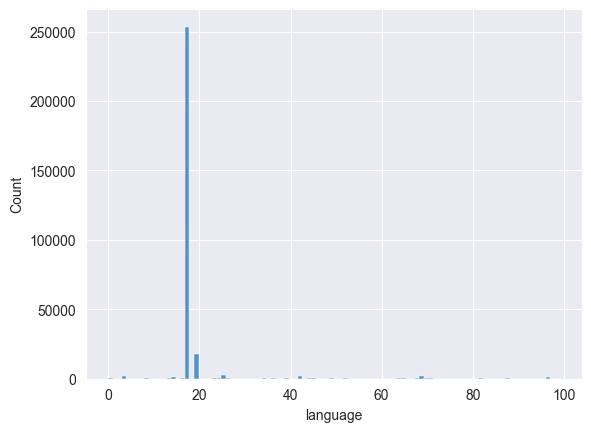

In [108]:
sns.histplot(df["language"], bins=100)
plt.show()

In [115]:
count_languages = defaultdict(int)
for index, row in df.iterrows():
    count_languages[int(row["language"])] += 1
print(count_languages)

defaultdict(<class 'int'>, {17: 253550, 19: 18021, 44: 274, 3: 2156, 69: 1792, 12: 129, 25: 2854, 97: 1007, 82: 586, 34: 726, 24: 487, 68: 299, 16: 246, 70: 656, 65: 364, 14: 1253, 8: 324, 26: 249, 9: 59, 52: 727, 45: 271, 36: 240, 42: 2132, 54: 59, 0: 166, 57: 91, 11: 67, 39: 286, 41: 123, 88: 368, 23: 270, 56: 103, 37: 79, 38: 121, 49: 570, 71: 200, 46: 100, 48: 148, 20: 77, 64: 492, 55: 40, 18: 113, 72: 134, 13: 531, 99: 69, 93: 79, 15: 32, 4: 9, 73: 66, 31: 112, 7: 98, 1: 68, 94: 10, 81: 57, 27: 73, 74: 36, 83: 56, 78: 128, 98: 76, 29: 122, 60: 136, 87: 11, 40: 35, 10: 49, 89: 18, 77: 104, 66: 36, 96: 17, 28: 68, 92: 74, 33: 56, 2: 57, 61: 60, 84: 15, 32: 41, 30: 60, 50: 24, 43: 50, 53: 60, 21: 75, 76: 53, 85: 19, 79: 16, 90: 58, 5: 5, 35: 10, 86: 3, 22: 13, 75: 18, 80: 8, 6: 29, 51: 5, 59: 1, 91: 1, 62: 1, 63: 1, 95: 5, 47: 2, 67: 3, 58: 4})


-> 17 was english, which has way more tracks than all the other languages
=> Undersampling for 17 and 19, oversampling for some with very low representation

count    294932.000000
mean         19.094757
std          10.186960
min           0.000000
25%          17.000000
50%          17.000000
75%          17.000000
max          99.000000
Name: language, dtype: float64